In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from LQN_utils_state_save_parallel import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby

In [2]:
import networkx as nx
import igraph as ig
import itertools


# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환


# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    # 노드 매핑 (문자열 → 정수 변환)
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}

    # 엣지 및 가중치 추출
    edges = []
    weights = []
    for u, v, data in nx_graph.edges(data=True):
        edges.append((node_map[u], node_map[v]))  # 정수 인덱스로 변환된 엣지 추가
        weights.append(data['weight'])  # 가중치 추가

    # iGraph 객체 생성
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))  # 노드 추가
    ig_graph.add_edges(edges)  # 엣지 추가
    ig_graph.es['weight'] = weights  # 가중치 추가
    return ig_graph


# Canonical Form 생성
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]  # 색상(label) 설정
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])  # canonical permutation
    permuted = ig_graph.permute_vertices(perm)  # 정렬 적용
    return tuple(map(tuple, permuted.get_adjacency().data))  # Immutable 변환


# 그래프 리스트 처리 및 중복 제거
def process_and_deduplicate(graph_list):
    canonical_set = set()  # 중복 제거를 위한 set
    for graph in graph_list:
        ig_graph = nx_to_igraph(graph)  # NetworkX → iGraph 변환
        canonical_form = canonical_form_with_weights(ig_graph)  # Canonical Form 생성
        canonical_set.add(canonical_form)  # 중복 제거
    return canonical_set

In [3]:
# EPM bipartite graph 생성
graph_list = EPM_bipartite_graph_generator_old(num_system=3, num_ancilla=1, type=0)

# 중복 제거된 canonical forms 추출
unique_graphs = process_and_deduplicate(graph_list)

# 결과 출력
print(f"Original graph count: {len(graph_list)}")
print(f"Unique graph count: {len(unique_graphs)}")


Original graph count: 3264
Unique graph count: 106


In [5]:
unique_graphs

{((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 0, 0),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 1, 1),
  (1, 1, 0, 0, 0, 1, 0, 0),
  (1, 1, 0, 0, 0, 1, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 0, 1, 0, 1),
  (0, 0, 0, 1, 1, 0, 0, 0),
  (0, 0, 1, 0, 0, 1, 0, 0),
  (0, 0, 1, 0, 0, 1, 1, 0),
  (0, 1, 0, 1, 1, 0, 0, 0),
  (1, 0, 0, 0, 1, 0, 0, 0),
  (1, 1, 0, 0, 0, 0, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 0, 0, 1, 0, 0, 1),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 0, 0, 1, 0),
  (0, 1, 0, 0, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 1, 1),
  (1, 0, 0, 1, 0, 1, 0, 0),
  (1, 1, 0, 0, 0, 1, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 1, 0, 0, 0, 0, 1),
  (0, 1, 0, 0, 0, 1, 0, 0),
  (0, 0, 0, 0, 1, 0, 1, 0),
  (0, 0, 0, 1, 0, 1, 0, 0),
  (0, 0, 1, 0, 1, 0, 1, 1),
  (1, 0, 0, 1, 0, 1, 0, 0),
  (1, 1, 0, 0, 0, 1, 0, 0)),
 ((0, 0, 0, 0, 0, 0, 1, 1),
  (0, 0, 1, 0, 0, 1, 0, 0),
  (0, 1, 0, 0, 0, 0, 0, 1),
  (0, 0, 0, 0, 1

## 아래는 결과가 맞는지 확인하는 과정

In [62]:
import networkx as nx 
import igraph as ig
import itertools
from collections import defaultdict

# EPM bipartite graph 생성 함수
def EPM_bipartite_graph_generator_old(num_system, num_ancilla, type): 
    results = []  # 결과 저장 리스트
    num_total = num_system + num_ancilla

    # red-blue 조합 생성 (type=0 가정)
    red_blue_combinations, num_combi = list_all_combinations_with_duplication(num_system, num_ancilla)

    # ancilla 조합 생성
    ancilla_combinations_pre = generate_combinations(num_total)
    ancilla_combinations = list(itertools.product(ancilla_combinations_pre, repeat=num_ancilla))

    for rb_comb in red_blue_combinations:
        if num_ancilla != 0:
            for bl_comb in ancilla_combinations:
                B = nx.Graph()
                B.add_nodes_from(range(2 * num_total))
                mapping = {}

                # red-blue 엣지 추가
                for rb_index, vt in enumerate(rb_comb):
                    red = num_total + vt[0]
                    blue = num_total + vt[1]

                    B.add_edge(rb_index, red, weight=1.0)
                    B.add_edge(rb_index, blue, weight=2.0)

                    mapping[rb_index] = 'S_' + str(rb_index)
                    mapping[num_total + rb_index] = rb_index

                # ancilla 엣지 추가
                for anc_index, vt_list in enumerate(bl_comb):
                    for vt_inx in vt_list:
                        B.add_edge(num_system + anc_index, num_total + vt_inx, weight=3) 

                    mapping[num_system + anc_index] = 'A_' + str(anc_index)
                    mapping[num_total + num_system + anc_index] = num_system + anc_index

                # 노드 속성 추가
                for node_index in range(2 * num_total):
                    if node_index < num_system:
                        B.nodes[node_index]['category'] = 'system_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    elif node_index < num_total:
                        B.nodes[node_index]['category'] = 'ancilla_nodes'
                        B.nodes[node_index]['bipartite'] = 0
                    else:
                        B.nodes[node_index]['category'] = 'sculpting_nodes'
                        B.nodes[node_index]['bipartite'] = 1

                B = nx.relabel_nodes(B, mapping)  # 노드 이름 변경

                if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                    results.append(B)
        else:
            B = nx.Graph()
            B.add_nodes_from(range(2 * num_total))
            mapping = {}

            for rb_index, vt in enumerate(rb_comb):
                red = num_total + vt[0]
                blue = num_total + vt[1]

                B.add_edge(rb_index, red, weight=1.0)
                B.add_edge(rb_index, blue, weight=2.0)

                mapping[rb_index] = 'S_' + str(rb_index)
                mapping[num_total + rb_index] = rb_index

            for node_index in range(2 * num_total):
                if node_index < num_system:
                    B.nodes[node_index]['category'] = 'system_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                elif node_index < num_total:
                    B.nodes[node_index]['category'] = 'ancilla_nodes'
                    B.nodes[node_index]['bipartite'] = 0
                else:
                    B.nodes[node_index]['category'] = 'sculpting_nodes'
                    B.nodes[node_index]['bipartite'] = 1

            B = nx.relabel_nodes(B, mapping)

            if all(len(list(B.neighbors(node))) >= 2 for node in B.nodes):
                results.append(B)

    return results  # 최종 결과 반환

# NetworkX -> iGraph 변환
def nx_to_igraph(nx_graph):
    node_map = {node: idx for idx, node in enumerate(nx_graph.nodes)}
    edges = []
    weights = []
    for u, v, data in nx_graph.edges(data=True):
        edges.append((node_map[u], node_map[v]))
        weights.append(data['weight'])
    ig_graph = ig.Graph()
    ig_graph.add_vertices(len(node_map))
    ig_graph.add_edges(edges)
    ig_graph.es['weight'] = weights
    return ig_graph

# Canonical Form 생성
def canonical_form_with_weights(ig_graph):
    ig_graph.vs['color'] = [v['weight'] for v in ig_graph.es]
    perm = ig_graph.canonical_permutation(color=ig_graph.vs['color'])
    permuted = ig_graph.permute_vertices(perm)
    return tuple(map(tuple, permuted.get_adjacency().data))

# 그래프 리스트 처리 및 그룹화
def process_and_group(graph_list):
    groups = defaultdict(list)
    canonical_forms = {}
    grouped_graphs = defaultdict(list)

    for idx, graph in enumerate(graph_list):
        ig_graph = nx_to_igraph(graph)
        canonical_form = canonical_form_with_weights(ig_graph)

        if canonical_form not in canonical_forms:
            canonical_forms[canonical_form] = len(canonical_forms) + 1
        group_id = canonical_forms[canonical_form]
        groups[group_id].append(idx + 1)
        grouped_graphs[group_id].append(graph)  # 그래프 저장

    return groups, grouped_graphs

# 예제 실행
graphs = EPM_bipartite_graph_generator_old(3, 1, 0)
grouped_results, grouped_graphs = process_and_group(graphs)

print("Grouped Results:")
for group_id, members in grouped_results.items():
    print(f"Group {group_id}: {members}")


Grouped Results:
Group 1: [1, 5, 49, 53, 169, 181, 257, 269, 817, 821, 865, 869, 985, 997, 1073, 1085, 2177, 2189, 2265, 2277, 2393, 2397, 2441, 2445, 2993, 3005, 3081, 3093, 3209, 3213, 3257, 3261]
Group 2: [2, 6, 50, 54, 818, 822, 866, 870, 2178, 2190, 2266, 2278, 2994, 3006, 3082, 3094]
Group 3: [3, 7, 51, 55, 819, 823, 867, 871, 2179, 2191, 2267, 2279, 2995, 3007, 3083, 3095]
Group 4: [4, 8, 52, 56, 820, 824, 868, 872, 2180, 2192, 2268, 2280, 2996, 3008, 3084, 3096]
Group 5: [9, 19, 29, 35, 97, 107, 185, 191, 301, 303, 457, 459, 565, 567, 681, 683, 825, 835, 845, 851, 913, 923, 1001, 1007, 1661, 1663, 1817, 1819, 2469, 2471, 2585, 2587]
Group 6: [10, 20, 30, 36, 98, 108, 186, 192, 302, 304, 458, 460, 566, 568, 682, 684, 826, 836, 846, 852, 914, 924, 1002, 1008, 1662, 1664, 1818, 1820, 2470, 2472, 2586, 2588]
Group 7: [11, 21, 31, 37, 99, 109, 153, 157, 165, 177, 187, 193, 241, 245, 253, 265, 827, 837, 847, 853, 915, 925, 969, 973, 981, 993, 1003, 1009, 1057, 1061, 1069, 1081, 1129,

In [63]:
grouped_results.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106])

In [64]:
grouped_graphs[1][0]

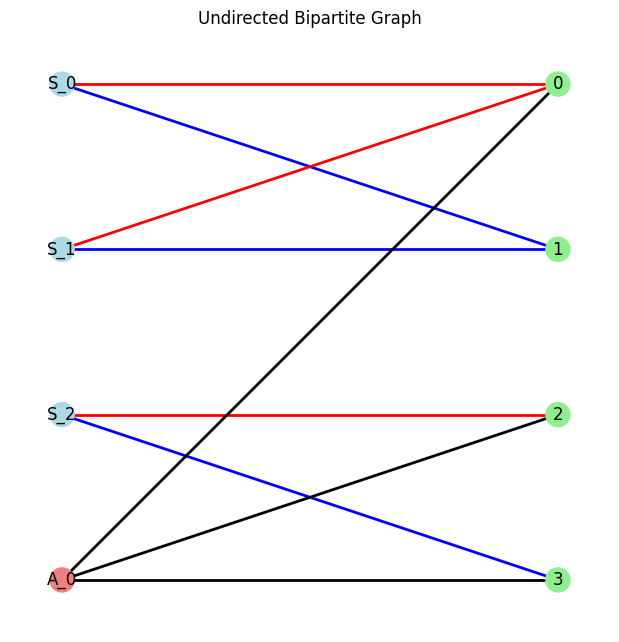

In [65]:
Draw_EPM_bipartite_graph(grouped_graphs[2][0])

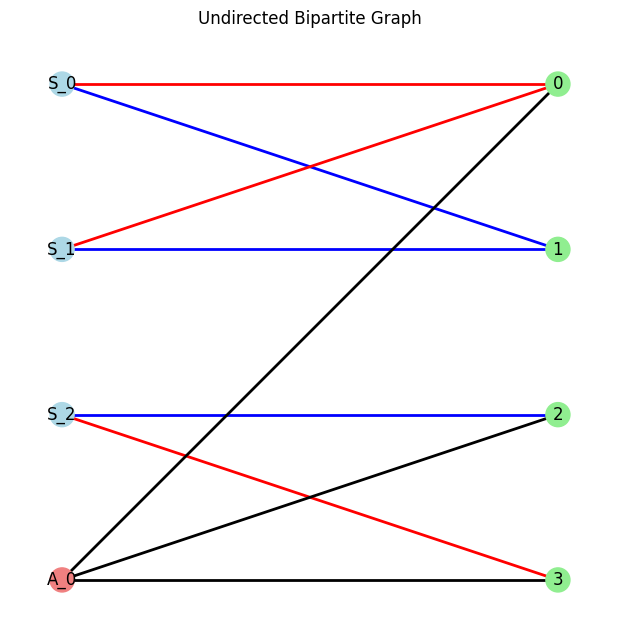

In [66]:
Draw_EPM_bipartite_graph(grouped_graphs[2][1])

In [67]:
grouped_graphs[1]

for i in grouped_graphs[3]:
    if not nx.is_isomorphic(grouped_graphs[3][0], i):
        print("not isomorphic")

In [68]:
len(grouped_graphs)

106

In [71]:
grouped_graphs.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106])

In [73]:
grouped_graphs[1][0]

In [77]:
for i in list(grouped_graphs.keys()):
    for j in grouped_graphs[i]:
        if not nx.is_isomorphic(grouped_graphs[i][0], j):
            print("not isomorphic", i)